# **Fundamental & Traditional Filters**
Researchers came up with filters to denoise an image. Most of the filters were specific to the type of noise the image has. There are several types of noises like Gaussian noise, Poisson noise, Speckle noise, Salt and Pepper noise, etc. There are specific filters for each type of noise. Hence, the first step to denoise an image using traditional filters is to identify the type of noise present in the image. After identifying that, we can go ahead and apply the specific filter. To identifying the type of noise, there are certain mathematical formulas to help us guess the type of noise. Or else a domain expert can decide it just by looking at the image. There are also some filters that work on any type of noise.
<br>
<br>

There are tons of filters available for denoising an image.In this datasets I will be discussing the **Non-Local Means (NLM)** algorithm which is seen to be working very well to denoise an image. Other filter like Median filter (MF), Adaptive Median filter (AMF) and Adaptive Wiener filter (AWF) will be implemented. The filters will be used to remove the additive noises present in the MRI images.
<br>
<br>

---
[Paper Link](http://tiny.cc/d0gbtz)<br>
Here is Gaussian noise : 

![An image](https://api.intechopen.com/media/chapter/58070/media/F1.png)

---

**Data Preparation**

In [1]:
#Lets import libaries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage #https://scikit-image.org/docs/dev/user_guide/getting_started.html
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [3]:
#Mount 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Extract zip files to a destination directory,
# https://askubuntu.com/a/1049564
if 'SIDD_Small_sRGB_Only' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
    get_ipython().system_raw('7z x SIDD_Small_sRGB_Only.zip -o/content/ && rm SIDD_Small_sRGB_Only.zip')

Downloading...
From: https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
To: /content/SIDD_Small_sRGB_Only.zip
6.62GB [02:22, 46.5MB/s]


In [62]:
# Download files from Google drive using sharable link,
# https://stackoverflow.com/a/50670037/7697658
if 'Mi3_Aligned' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1MrcCSnM3Weu7Wi-n0iNBxfFYlHy0ZUpX
    get_ipython().system_raw('7z x Mi3_Aligned.zip -o/content/ && rm Mi3_Aligned.zip')

Downloading...
From: https://drive.google.com/uc?id=1MrcCSnM3Weu7Wi-n0iNBxfFYlHy0ZUpX
To: /content/Mi3_Aligned.zip
2.71GB [00:39, 69.0MB/s]


In [65]:
def get_images_paths(root_dir_ssid , root_dir_mi):
    # Getting SSID dataset images
    root = pathlib.Path(root_dir_ssid)
    img_paths = list(root.rglob("*.PNG*"))
    img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-3]
        if img_type=="NOISY":
            noisy_lst.append(p)
        elif img_type=="GT":
            gt_lst.append(p)
        
    # Getting mi dataset images
    root = pathlib.Path(root_dir_mi)
    img_paths = list(root.rglob("*.bmp*"))
    img_paths_lst = [str(path) for path in img_paths]

    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-1]
        if "Noisy" in img_type:
            noisy_lst.append(p)
        elif "Reference" in img_type:
            gt_lst.append(p)
            gt_lst.append(p)
        
    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst)
    return noisy_array, gt_array



In [48]:
noisy_array = get_images_paths("SIDD_Small_sRGB_Only")
noisy_array

(array(['SIDD_Small_sRGB_Only/Data/0057_003_G4_00100_00125_5500_L/NOISY_SRGB_010.PNG'],
       dtype='<U75'), array([], dtype=float64))

In [49]:
gt_array = get_images_paths("SIDD_Small_sRGB_Only")
gt_array

(array(['SIDD_Small_sRGB_Only/Data/0057_003_G4_00100_00125_5500_L/NOISY_SRGB_010.PNG'],
       dtype='<U75'), array([], dtype=float64))

In [67]:
from sklearn.model_selection import train_test_split

noisy_array_paths, gt_array_paths = get_images_paths("SIDD_Small_sRGB_Only", "Mi3_Aligned")
noisy_train_paths, noisy_test_paths, gt_train_paths, gt_test_paths = train_test_split(noisy_array_paths, gt_array_paths, test_size=0.20, random_state=2)

In [68]:
print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(192,)
(48,)
(192,)
(48,)


In [69]:
#get gt_images in memory
def get_images_in_mem(images_paths):
  images_lst = []
  for img_path in tqdm(images_paths):
    img = cv2.imread(img_path)
    img =  cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    img = cv2.resize(img ,(256,256))
    images_lst.append(img)
  return np.array(images_lst)
  

In [70]:
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images =  get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images =  get_images_in_mem(gt_test_paths)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_train_images.shape)


(192, 256, 256, 3)
(48, 256, 256, 3)
(192, 256, 256, 3)
(192, 256, 256, 3)


# **Traditional Filter: Non-local means**

In [73]:
# Source : https://github.com/scikit-image/scikit-image/blob/master/skimage/restoration/non_local_means.py
# Paper : https://www.researchgate.net/publication/284568577_Non-Local_Means_Denoising/fulltext/58ac628d4585153353950cd4/Non-Local-Means-Denoising.pdf
from skimage.restoration import denoise_nl_means , estimate_sigma

def inference_images(noisy_images):
  dn_images = []
  for i in tqdm(range(len(noisy_images))):
    sigma_est =  np.mean(estimate_sigma(noisy_images[i] , multichannel = True))
    patch_kw = dict(patch_size=5,      # 5x5 patches
                    patch_distance=6,  # 13x13 search area
                    multichannel=True)
    dni = denoise_nl_means(noisy_images[i], h=1.15 * sigma_est, sigma=sigma_est, fast_mode=False,**patch_kw)
    dn_images.append(dni)
  return np.array(dn_images)
denoised_images =  inference_images(noisy_test_images)


Text(0.5, 1.0, 'Predicted')

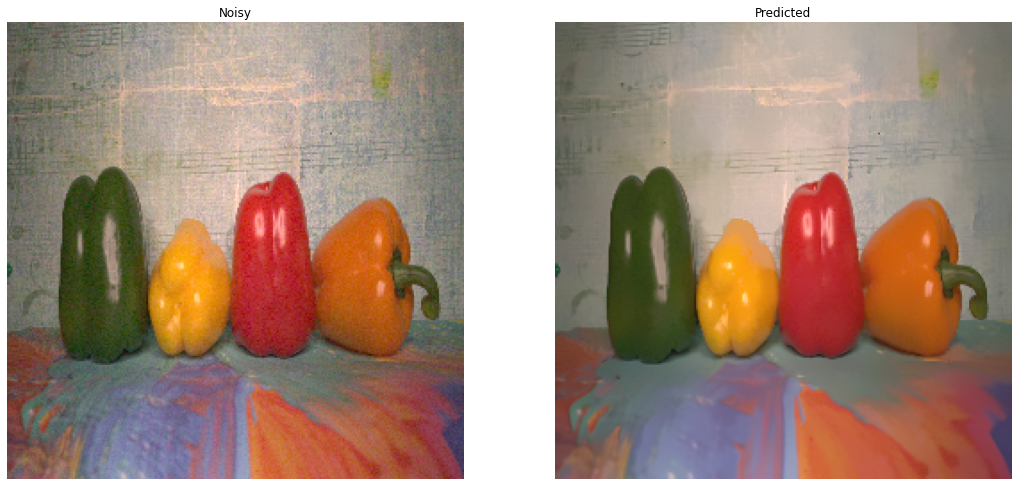

In [74]:
#showing the images from the text dataset
idx = 12 
f,ax = plt.subplots(1,2,figsize =(18 , 18))
ax[0].imshow(noisy_test_images[idx])
ax[0].axis('off')
ax[0].set_title('Noisy')

ax[1].imshow(denoised_images[idx]/255)
ax[1].axis('off')
ax[1].set_title('Predicted')

So the spliting and preditct is correct

In [80]:
from skimage.metrics import peak_signal_noise_ratio

original_mean = 0 
predict_mean = 0
for gt_img , noisy_img , predicted_img  in zip(gt_test_images , noisy_test_images , denoised_images):
  original_mean += peak_signal_noise_ratio(gt_img , noisy_img)
  predict_mean += peak_signal_noise_ratio(gt_img , predicted_img)

original_mean /= gt_test_images.shape[0]
predict_mean  /= gt_test_images.shape[0]
print("Original Value of Peak Singal Noise Ration = " , original_mean)
print("Predicted value of Peak Singal Noise Ration = " , predict_mean)

Original Value of Peak Singal Noise Ration =  28.281884957703653
Predicted value of Peak Singal Noise Ration =  32.34597064947473


In [79]:
from skimage.metrics import structural_similarity as ssim

ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, denoised_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.6475486637671014
Predicted average gt-predicted SSIM -> 0.8060669239064264


*END*